# Tabular Data

## Import Libraries

In [87]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Normalization, StringLookup, CategoryEncoding, IntegerLookup

## Load Dataset
- The *Titanic* dataset is a binary classification problem
- TensorFlow can be useful for setting up data pipelines
    - Handles large amounts of complex data
    - Uses the `tf.data` API
- To create an input pipeline, we need a data source

In [88]:
TRAIN_DATA_URL = 'https://storage.googleapis.com/tf-datasets/titanic/train.csv'
TEST_DATA_URL = 'https://storage.googleapis.com/tf-datasets/titanic/eval.csv'

train_file_path = tf.keras.utils.get_file('train.csv', TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file('eval.csv', TEST_DATA_URL)

## Prepare & Analyze Data


### Train/Val/Test Split

In [89]:
train = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path)

test, val = train_test_split(test, test_size=0.5)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

627 train examples
132 validation examples
132 test examples


### Exploratory Analysis

<Axes: >

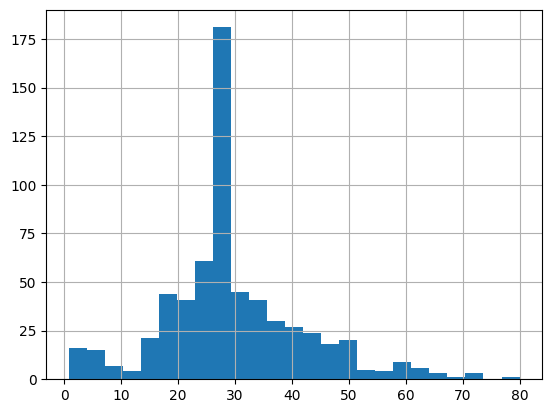

In [90]:
train.age.hist(bins=25)

<Axes: ylabel='sex'>

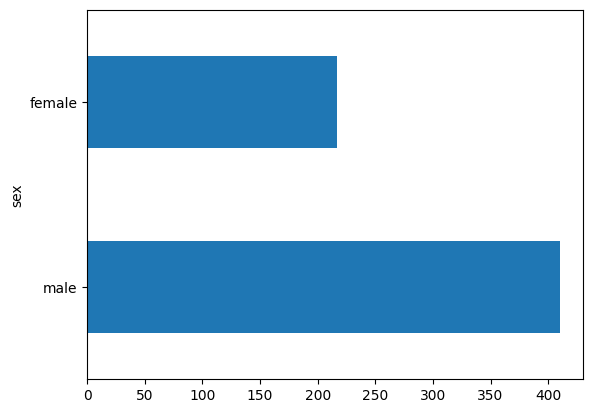

In [91]:
train.sex.value_counts().plot(kind='barh')

<Axes: ylabel='class'>

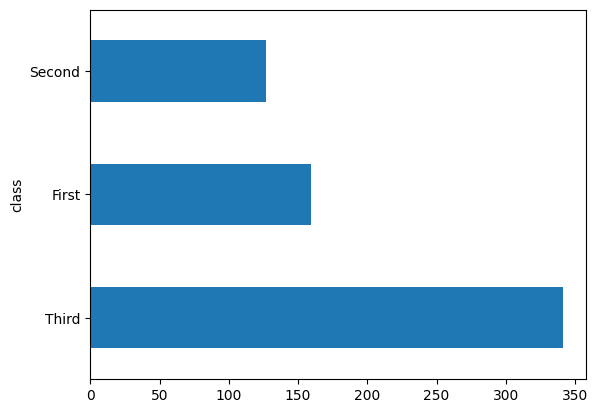

In [92]:
train['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survived')

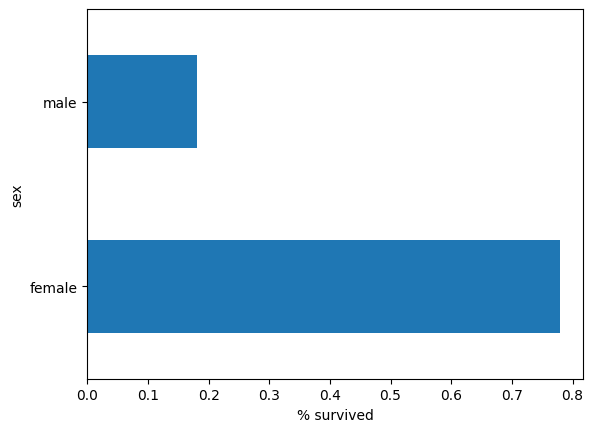

In [93]:
train.groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survived')

In [94]:
train[(train.age < 18) & (train['class'] == 'First')].head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
221,1,female,17.0,1,0,108.9000,First,C,Cherbourg,n
315,1,female,14.0,1,2,120.0000,First,B,Southampton,n
395,1,male,17.0,0,2,110.8833,First,C,Cherbourg,n
489,1,female,15.0,0,1,211.3375,First,B,Southampton,n
547,1,female,17.0,1,0,57.0000,First,B,Southampton,n


## `tf.data` API
### Data Pipeline
- TensorFlow 2.0 documentation
    - [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
    - [tf.data.Dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
- This helper function will:
    - Remove label feature
    - Convert DataFrame to Tensor dataset
    - Shuffle and batch records
- Using `prefetch` lets us prepare the next batch while the model is processing the current batch
    - Note that it requires GPU

In [95]:
# dataframe = train.copy()

# data = tf.data.Dataset.from_tensor_slices((dict(dataframe), dataframe.pop('survived')))
# for item in data:
#   print(item)

In [96]:
def df_to_dataset(df, shuffle=True, batch_size=3):
    df = df.copy()
    labels = df.pop('survived')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

train_ds = df_to_dataset(train)
train_ds

<_PrefetchDataset element_spec=({'sex': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'age': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'n_siblings_spouses': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'parch': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'fare': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'class': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'deck': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'embark_town': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'alone': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### Sample Batch
- Each batch contains 3 passengers

In [97]:
[(train_features, label_batch)] = train_ds.take(1)
label_batch

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([0, 0, 0])>

In [98]:
print('All Features:', list(train_features.keys()))
print('Ages:', train_features['age'])
print('Labels:', label_batch )

All Features: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
Ages: tf.Tensor([57. 18. 28.], shape=(3,), dtype=float64)
Labels: tf.Tensor([0 0 0], shape=(3,), dtype=int64)


## Feature Engineering
- Feature engineering is the process to use domain knowledge in order to extract features from raw data
    - Normalizing
    - One-hot encoding

### Normalize Layers
- [adapt()](https://www.tensorflow.org/guide/keras/preprocessing_layers#the_adapt_method)


In [99]:
train.describe()


,survived,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000,627.000000
mean,0.387560,29.631308,0.545455,0.379585,34.385399
std,0.487582,12.511818,1.151090,0.792999,54.597730
min,0.000000,0.750000,0.000000,0.000000,0.000000
25%,0.000000,23.000000,0.000000,0.000000,7.895800
50%,0.000000,28.000000,0.000000,0.000000,15.045800
75%,1.000000,35.000000,1.000000,0.000000,31.387500
max,1.000000,80.000000,8.000000,5.000000,512.329200


In [100]:
def get_normalization_layer(name, dataset):
    normalizer = Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name]).unbatch()
    normalizer.adapt(feature_ds)
    return normalizer

In [101]:
# before normalizing
age_column = train_features['age']
age_column

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([57., 18., 28.])>

In [102]:
# after normalizing
numeric_layer = get_normalization_layer('age', train_ds)
numeric_layer(age_column)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 2.189173  , -0.93036777, -0.13048555], dtype=float32)>

### One-Hot Encoding
- [StringLookup](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup)
- [IntegerLookup](https://www.tensorflow.org/api_docs/python/tf/keras/layers/IntegerLookup) 
- [CategoryEncoding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/CategoryEncoding)


In [103]:
train.embark_town.unique()

array(['Southampton', 'Cherbourg', 'Queenstown', 'unknown'], dtype=object)

In [104]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = StringLookup(max_tokens=max_tokens)
    else:
        index = IntegerLookup(max_tokens=max_tokens)
    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = CategoryEncoding(num_tokens=index.vocabulary_size())
    return lambda feature: encoder(index(feature))

In [105]:
# before one-hot encoding
embark_town_column = train_features['embark_town']
embark_town_column

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'Southampton', b'Southampton', b'Southampton'], dtype=object)>

In [106]:
# after one-hot encoding
categorical_layer = get_category_encoding_layer('embark_town', train_ds, 'string')
categorical_layer(embark_town_column)

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 0., 0.], dtype=float32)>

## Creating Pipeline

In [107]:
BATCH_SIZE = 64
train_ds = df_to_dataset(train, batch_size=BATCH_SIZE)
val_ds = df_to_dataset(val, shuffle=False, batch_size=BATCH_SIZE)
test_ds = df_to_dataset(test, shuffle=False, batch_size=BATCH_SIZE)

all_inputs = []
encoded_features = []

# numeric features
numeric_columns = ['age', 'n_siblings_spouses', 'parch', 'fare']
for column_name in numeric_columns:
    numeric_column = tf.keras.Input(shape=(1,), name=column_name)
    normalization_layer = get_normalization_layer(column_name, train_ds)
    encoded_numeric_column = normalization_layer(numeric_column)
    all_inputs.append(numeric_column)
    encoded_features.append(encoded_numeric_column)

# categorical features
categorical_columns = ['sex', 'class', 'embark_town', 'deck', 'alone']
for column_name in categorical_columns:
    categorical_column = tf.keras.Input(shape=(1,), name=column_name, dtype='string')
    encoding_layer = get_category_encoding_layer(column_name, train_ds, dtype='string', max_tokens=5)
    encoded_categorical_column = encoding_layer(categorical_column)
    all_inputs.append(categorical_column)
    encoded_features.append(encoded_categorical_column)

In [ ]:
# examine inputs
all_inputs

[<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=age>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=n_siblings_spouses>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=parch>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=fare>,
 <KerasTensor shape=(None, 1), dtype=string, sparse=False, ragged=False, name=sex>,
 <KerasTensor shape=(None, 1), dtype=string, sparse=False, ragged=False, name=class>,
 <KerasTensor shape=(None, 1), dtype=string, sparse=False, ragged=False, name=embark_town>,
 <KerasTensor shape=(None, 1), dtype=string, sparse=False, ragged=False, name=deck>,
 <KerasTensor shape=(None, 1), dtype=string, sparse=False, ragged=False, name=alone>]

In [ ]:
# exmaine encoded features
encoded_features

[<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_19>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_20>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_21>,
 <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_22>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_24>,
 <KerasTensor shape=(None, 4), dtype=float32, sparse=False, ragged=False, name=keras_tensor_26>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, ragged=False, name=keras_tensor_28>,
 <KerasTensor shape=(None, 5), dtype=float32, sparse=False, ragged=False, name=keras_tensor_30>,
 <KerasTensor shape=(None, 3), dtype=float32, sparse=False, ragged=False, name=keras_tensor_32>]

## Neural Network Model

### Design Model
- Working with tabular data requires more preprocessing than imagery
- However the model design is pretty similar to Fashion-MNIST
- Some differences
    - Don't need to flatten cause we're not using grid values
    - Uses a dropout to prevent overfitting
    - Final output is only a single node
    - Switched to `BinaryCrossentropy` for loss function


In [110]:
# design
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128, activation='relu')(all_features)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

# compile
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Train Model

In [111]:
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6259 - loss: 0.6755 - val_accuracy: 0.6667 - val_loss: 0.5828
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7154 - loss: 0.5463 - val_accuracy: 0.7121 - val_loss: 0.5016
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7627 - loss: 0.4679 - val_accuracy: 0.7652 - val_loss: 0.4526
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8050 - loss: 0.4301 - val_accuracy: 0.8030 - val_loss: 0.4259
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8270 - loss: 0.4078 - val_accuracy: 0.8258 - val_loss: 0.4115
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8352 - loss: 0.3863 - val_accuracy: 0.8258 - val_loss: 0.4100
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8447 - loss: 0.3966 - val_accuracy: 0.8333 - val_loss: 0.4007
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8354 - loss: 0.4015 - val_accuracy: 0.8333 - val_loss

### Evaluate Model

In [112]:
loss, accuracy = model.evaluate(test_ds)
print('Accuracy', accuracy)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7808 - loss: 0.4709
Accuracy 0.7803030014038086


### Export Model

In [113]:
model.save('classifier.keras')